In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Import Section

In [2]:
!pip install iterative-stratification

In [79]:
!pip install gensim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import nltk
from nltk.corpus import stopwords
import spacy
import string
import re
from wordcloud import WordCloud
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, InputLayer, Dense, GlobalAveragePooling1D, SimpleRNN, Dropout, Bidirectional, LSTM
from tensorflow.keras.models import load_model
import pickle
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, multilabel_confusion_matrix, precision_score, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import NearestNeighbors

In [4]:
# Dataset import
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Filter_Toxic_Comments_dataset.csv")
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


# Exploratory Data Analysis

Tha dataset presents 8 columns:
* "comment_text": contains the text of the comment submitted to labeling
* "toxic": generally offensive comment, insulting or agressive, which show contempt towards somebody
* "severe_toxic": extreme cases of "toxic" category
* "obscene": explicit vulgar comment, with swearwords and/or sexual reference
* "threat": contains directly or indirectly a threat against somebody
* "insult": personal attacks or offensive names
* "identity_hate": racism hate type
* sum_injurious: equivalent to an "or" boolean operator applied on the 6 labeling categories

In [5]:
print(f"Number of examples: {df.shape[0]}")

Number of examples: 159571


Each datapoint presents labels, among the selection of 6 different kinds: in the corresponding label column '1' indicates the presence of this label for the comment, while '0' means its absence. </br>
Now let's take a look to the different labels distributions: first a function is created to calculate for each label the percentage of positive and negative comments.

In [6]:
def perc_count(y):
  counts = y.value_counts()

  mod_0 = y.unique()[0]
  mod_0_perc = round(counts[mod_0]/counts.sum()*100, 2)

  mod_1 =y.unique()[1]
  mod_1_perc = round(counts[mod_1]/counts.sum()*100, 2)

  return mod_0_perc, mod_1_perc

Then, this function is used to create a dict where the data for all labels are visible.

In [7]:
labels_perc = {}

for col in df.columns:
  if col not in ['comment_text', 'sum_injurious']:
    counts = perc_count(df[col])
    labels_perc[col] = [counts[0], counts[1]]

  if col == 'sum_injurious':
    count_1 = (df['sum_injurious'] >= 1).sum()
    labels_perc[col] = [round((df.shape[0]-count_1)/df.shape[0]*100,2), round(count_1/df.shape[0]*100,2)]

df_labels_perc = pd.DataFrame(labels_perc, index=['% no', '% yes'])
df_labels_perc

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
% no,90.42,99.0,94.71,99.7,95.06,99.12,89.83
% yes,9.58,1.0,5.29,0.3,4.94,0.88,10.17


It is a clear case of imbalanced dataset: nearly 90% of the comments are not from haters, and don't have to be blocked, whereas the label "threat" for instance is present only in 0.3% of the observations.

It is important to check if there are some duplicated rows in the dataset.

In [8]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of duplicated rows: 0


It is possible to check if some comments are missing, or are empty strings.

In [9]:
invalid_rows = df[df['comment_text'].isna() | (df['comment_text'].str.strip() == '')]
print(invalid_rows)

Empty DataFrame
Columns: [comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate, sum_injurious]
Index: []


It appears there is no observation in the dataset that present missing data in the comment_text or have only spaces.

It would be interesting to plot the distributions of comment_text length for each label.

In [10]:
# Creation of new column "length"
df['length'] = df['comment_text'].str.len()

# Min and max values of comments length in the whole dataset
min_value = df['length'].min()
min_value
max_value = df['length'].max()
max_value
print(f"The shortest comments presents {min_value} characters, \nwhile the longest {max_value} characters.")

The shortest comments presents 6 characters, 
while the longest 5000 characters.


Let's see if we can establish a correlation between length and toxicity of the comments.

In [11]:
# Shortest and longest comments in the dataset
df_min_max = df[(df['length'] == min_value) | (df['length'] == max_value)]

number_short = df_min_max[(df_min_max['length'] == min_value)].count().sum()
number_long = df_min_max[(df_min_max['length'] == max_value)].count().sum()

number_short_nontoxic = df_min_max[(df_min_max['sum_injurious'] == 0) & (df_min_max['length'] == min_value)].count().sum()
number_long_nontoxic = df_min_max[(df_min_max['sum_injurious'] == 0) & (df_min_max['length'] == max_value)].count().sum()

number_short_toxic = df_min_max[(df_min_max['sum_injurious'] != 0) & (df_min_max['length'] == min_value)].count().sum()
number_long_toxic = df_min_max[(df_min_max['sum_injurious'] != 0) & (df_min_max['length'] == max_value)].count().sum()

print(f"There are {number_short} comments whose length is the shortest:\n{number_short_nontoxic} are NOT toxic, {number_short_toxic} are toxic")
print(f"There are {number_long} comments whose length is the longest:\n{number_long_nontoxic} are NOT toxic, {number_long_toxic} are toxic")

There are 18 comments whose length is the shortest:
18 are NOT toxic, 0 are toxic
There are 378 comments whose length is the longest:
90 are NOT toxic, 288 are toxic


From these considerations, it could seem that toxic comments tend to be longer. </br>
To better understand this trend, it would be interesting to plot the length distribution of the comments for each label presence, and for the non toxic comments.

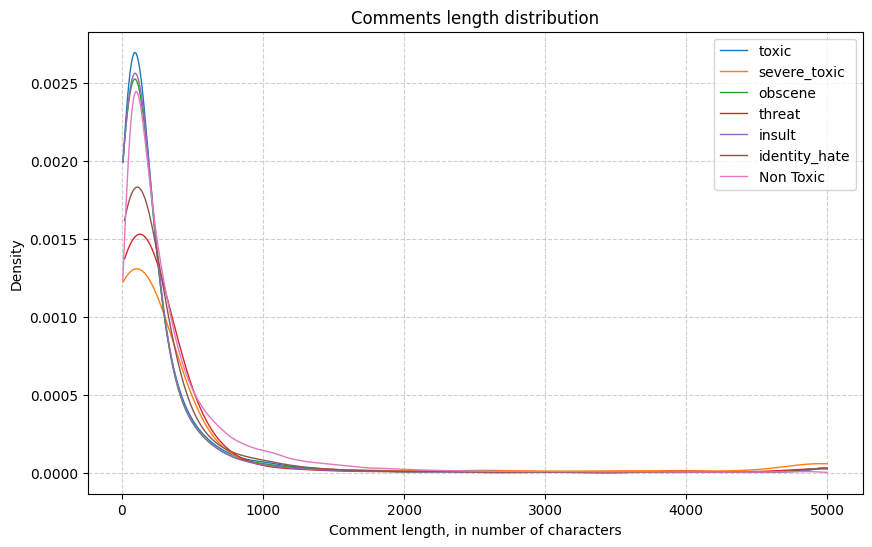

In [12]:
# Selection of the columns in the dataset corresponding to toxic labels
labels = df.columns[1:7]

# Storage of curves for reuse
curves = []

bandwidth = 'scott'

modal_value = []
mean_value = []

for lab in labels:
    df_lab = df[df[lab] == 1]['length']
    kde = gaussian_kde(df_lab, bw_method=bandwidth)
    x_vals = np.linspace(df_lab.min(), df_lab.max(), 500)
    kde_vals = kde(x_vals)

    # Store curves for later reuse
    curves.append((x_vals, kde_vals, lab))

    # Modal and mean
    idx_max = np.argmax(kde_vals)
    modal_value.append(int(x_vals[idx_max]))
    mean_value.append(int(df_lab.mean()))

# Non-toxic comments
df_nontoxic = df[df['sum_injurious'] == 0]['length']
kde = gaussian_kde(df_nontoxic, bw_method=bandwidth)
x_vals = np.linspace(df_nontoxic.min(), df_nontoxic.max(), 500)
kde_vals = kde(x_vals)
curves.append((x_vals, kde_vals, 'Non Toxic'))

idx_max = np.argmax(kde_vals)
modal_value.append(int(x_vals[idx_max]))
mean_value.append(int(df_nontoxic.mean()))

# Plot
plt.figure(figsize=(10, 6))
for x, y, lab in curves:
    plt.plot(x, y, lw=1, label=lab)

plt.title("Comments length distribution")
plt.xlabel("Comment length, in number of characters")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

At first glance, there is no correlation between comment length and toxicity. </br>
For the highest length values, it is strange to observe groups of outliers. A special view with a zoom on this part of the plot is done.

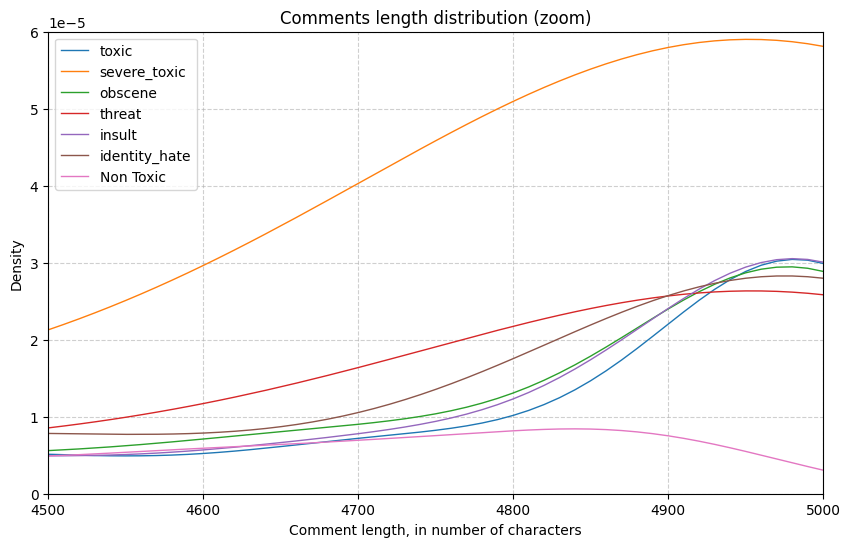

In [13]:
plt.figure(figsize=(10, 6))
for x, y, lab in curves:
    plt.plot(x, y, lw=1, label=lab)

plt.title("Comments length distribution (zoom)")
plt.xlabel("Comment length, in number of characters")
plt.ylabel("Density")
plt.xlim(4500, 5000)
plt.ylim(0, 0.00006)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Here, three observations can be made:
* non toxic comments have a decreasing distribution for higher length values. This is the typical behaviour one could expect for regular comments: beyond a length, less comments are present,
* all toxic comments present a strange behaviour: there is a local maximum in the distribution in the range [4900 - 5000],
* the 'severe-toxic' labelled comments have this local maximum much higher than the other labeled toxic comments. </br>
One possible interpretation is that many toxic comments are longer than 5000 characters but their length is truncated at 5000 (even if this would lead to a local maximum of exactly 5000 characters).

In order to better investigate the relation label - length, the mean length and modal length values are calculated for each label and reported in the dataframe below.

In [14]:
categories = labels.tolist() + ['Non toxic']
length_dict = {'Categorie': categories, 'Mean Length': mean_value, 'Modal Length': modal_value}
# Pandas dataframe creation to visualize the results
df_length = pd.DataFrame(length_dict)
df_length.sort_values('Mean Length', ascending=False)

,Categorie,Mean Length,Modal Length
1,severe_toxic,453,108
6,Non toxic,404,106
5,identity_hate,308,107
3,threat,307,128
0,toxic,295,88
2,obscene,286,88
4,insult,277,98


There are some disparities among the different labels: the 'toxic', 'obscene' and 'insult' labelled comments present mean length of less than 300 characters and modal length of less than 100 characters ; while 'severe_toxic', non-toxic, 'identity_hate' and 'threat' labelled comments have mean length beyond 300 characters and even beyond 450 for 'severe_toxic', and modal_length higher than 100 characters. </br>
It appears that 'severe_toxic' comments presents a specially long length, while general toxic comments (all other labelled combined) are shorter than non-toxic comments. This can be partly due to the outliers at very high length (>45000 characters) visible on the previous plot zoom. They can affect the mean length, but these comments are still particular as the modal lenght value is higher than the other toxic comments and very close to the non-toxic value ones. </br>
All other toxic labelled comments are shorter than non-toxic ones.

Finally, after exploring the comments shape with the length, it would be interesting to investigate about their contents with words clouds. </br>
To do so, it is essential to remove stopwords, and we take the occasion to proceed with the data cleaning completing the following actions:
* lower casing
* removing punctuation
* lemmatization
* removing english stopwords
* removing numbers

In [15]:
nltk.download('stopwords')

english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)

    return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# Function application to the dataset
#df['comment_cleaned'] = df['comment_text'].apply(data_cleaner)

In [17]:
# Saving the new dataframe with cleaned comments
#df.to_pickle("/content/drive/MyDrive/df_clean.pkl")
# Opening it
df = pd.read_pickle("/content/drive/MyDrive/df_clean.pkl")

In [18]:
# Selection of only text content for each label and for non-toxic comments
text_toxic = "".join(df[df['toxic']==1]['comment_cleaned'])
text_severe_toxic = "".join(df[df['severe_toxic']==1]['comment_cleaned'])
text_obscene = "".join(df[df['obscene']==1]['comment_cleaned'])
text_threat = "".join(df[df['threat']==1]['comment_cleaned'])
text_insult = "".join(df[df['insult']==1]['comment_cleaned'])
text_id_hate = "".join(df[df['identity_hate']==1]['comment_cleaned'])
text_non_toxic = "".join(df[df['sum_injurious']==0]['comment_cleaned'])

In [19]:
# Function to create word clouds together with the top 5 of the most frequent words
def word_cloud(text, title):
  plt.figure(figsize=(18, 10))

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.tight_layout(pad=5)
  plt.axis('off')
  plt.title(f"- Word Cloud for {title} labelled comments", fontsize = 30)
  plt.show()

  # Print the 5 most frequent words
  # First order the words from highest to lowest frequency
  sorted_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)
  # Visualize the top 5
  top5 = [item[0] for item in sorted_words[:5]]
  print(f"The 5 most common words for {title} labelled comments are: {top5}")
  print("\n")

In [20]:
# Function application:
word_cloud(text_toxic, "toxic")
word_cloud(text_severe_toxic, "severe toxic")
word_cloud(text_obscene, "obscene")
word_cloud(text_threat, "threat")
word_cloud(text_insult, "insult")
word_cloud(text_id_hate, "identity hate")
word_cloud(text_non_toxic, "non toxic")

Output hidden; open in https://colab.research.google.com to view.

# Train, test, validation split

In a highly imbalanced multi-label cases like this one, it is crucial to split the dataset in different sets using some stratified strategy. The best way to do it is using "MultilabelStratifiedShuffleSplit" from iterstrat.ml_stratifiers package. </br>
As this class is able to divide only 2 sets, it will be applied twice in order to obtain train, validation and test sets.

In [21]:
X = df['comment_cleaned']
Y = df[labels]

In [22]:
# Split to obtain the test set, equal to 15% of total examples
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=2)

for train_val_idx, test_idx in msss1.split(X, Y):
    X_train_val, Y_train_val = X.iloc[train_val_idx], Y.iloc[train_val_idx]
    X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]
    break


# Split of the remaining 85% of the dataset to obtain train set (70% of total examples) and validation set (15% of total examples):
val_relative_size = 0.15 / 0.85
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_relative_size, random_state=2)

for train_idx, val_idx in msss2.split(X_train_val, Y_train_val):
    X_train, Y_train = X_train_val.iloc[train_idx], Y_train_val.iloc[train_idx]
    X_val, Y_val = X_train_val.iloc[val_idx], Y_train_val.iloc[val_idx]
    break

In [23]:
# Check of the sets dimensions of X_train, Y_train, X_test, Y_test, X_val, Y_val
print(f"Shape of X_train: {X_train.shape} and shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape} and shape of Y_test: {Y_test.shape}")
print(f"Shape of X_val: {X_val.shape} and shape of Y_val: {Y_val.shape}")

Shape of X_train: (111699,) and shape of Y_train: (111699, 6)
Shape of X_test: (23936,) and shape of Y_test: (23936, 6)
Shape of X_val: (23936,) and shape of Y_val: (23936, 6)


These dimensions correspond to what was expected.

# Preprocessing

Considering the very high imbalance character of this dataset, it is important to enhance the code with techniques to handle dataset imbalance. </br>
In this preprocessing part, the following steps will be performed:
* Data augmentation: expansion of train set with new comments labelled with the 6 toxicity labels ;
* Vectorization of the comments (fit on the train set content, application of the tokenizer on test and validation sets) ;
* Oversampling with creation of artificial sequences using a SMOTE based technique applied to multi label datasets, still only on the train set.

## Data Augmentation

In Kaggle, the page of "Toxic Comment Classification Challenge" is found, and it appears that the studied dataset here could correspond to the train dataset of this challenge. </br>
On the Kaggle page a test set is present, which would correspond to new comments for us. We decide to add the labelled toxic comments to our train set, and check if there are some duplicates. </br>
This could decrease the imbalance dataset and helps the model to better predict labellization. </br>
Source: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview

In [24]:
# Import of the dataset containing the comment texts
df_add = pd.read_csv("/content/drive/MyDrive/test.csv")

In [25]:
# Import of the dataset with corresponding labels
df_add_lab = pd.read_csv("/content/drive/MyDrive/test_labels.csv")

In [26]:
# In the labels dataset, many observations don't have real labels, but '-1' default values
# Comments without label must be discarded
filter = (df_add_lab[labels] != -1).all(axis=1)
df_add_lab_filtered = df_add_lab[filter]

# Among the labeled comments, only the toxic ones are kept
filter2 = (df_add_lab_filtered[labels].sum(axis=1)) != 0
df2 = df_add_lab_filtered[filter2]

Now the dataset containing the text comments and the dataset with toxicity labels must be joined.

In [27]:
df_joined = pd.merge(df_add, df2, on="id", how="right")
df_to_add = df_joined.drop("id", axis = 1)
print(f"Quantity on comments in this new dataset: {len(df_to_add)}.")

Quantity on comments in this new dataset: 6243.


In [28]:
# Check the presence of eventual duplicated rows and missing/empty comments
print(f"Number of duplicated rows: {df_to_add.duplicated().sum()}")
invalid_rows = df_to_add[df_to_add['comment_text'].isna() | (df_to_add['comment_text'].str.strip() == '')]
print(invalid_rows)

Number of duplicated rows: 0
Empty DataFrame
Columns: [comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []


In [29]:
# Creation of new column "length"
df_to_add['length'] = df_to_add['comment_text'].str.len()
# Check of maximal length comments
max_value = df_to_add['length'].max()
print(max_value)

5000


The maximum comment length is equal to 5000 characters as for the previous dataset.</br>

In [30]:
# Data cleaning for the textual part
#df_to_add['comment_cleaned'] = df_to_add['comment_text'].apply(data_cleaner)

In [31]:
# Saving the new dataframe with cleaned comments
#df_to_add.to_pickle("/content/drive/MyDrive/df_to_add_clean.pkl")
# Opening it
df_to_add = pd.read_pickle("/content/drive/MyDrive/df_to_add_clean.pkl")

In [32]:
# Union of X_train and Y_train parts of the previous train set to prepare concatenation
train_df = pd.concat([X_train, Y_train], axis=1)

In [33]:
# In the dataframe with new observations, the columns order must be the same as previous train set
df_to_add = df_to_add[["comment_cleaned", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [34]:
# Concatenation between previous dataset and new dataset
df_tot_train = pd.concat([train_df, df_to_add], axis=0, ignore_index=True)
print(f"Number of observations in the new train set: {len(df_tot_train)}")

Number of observations in the new train set: 117942


As it is possible to have now duplicates (comments from our original dataset were present in the test dataset found on Kaggle), an additional check is done about duplicates.

In [35]:
print(f"Number of duplicated rows: {df_tot_train.duplicated().sum()}")

Number of duplicated rows: 777


In fact there are 777 duplicates that need to be eliminated form the train set before continuing.

In [36]:
# Drop of the duplicates
df_tot_train = df_tot_train.drop_duplicates()
print(f"The new number of observations in the dataset is {df_tot_train.shape[0]}.")

The new number of observations in the dataset is 117165.


In [37]:
# Separation between X and Y
X_tot_train = df_tot_train['comment_cleaned']
Y_tot_train = df_tot_train[labels]

Now, the new proportions of labels in the train dataset are:

In [38]:
new_labels_perc = {}
for i, lab in enumerate(labels):
  perc = round(sum(Y_tot_train[lab])/len(Y_tot_train)*100, 2)
  new_labels_perc[lab] = [(100-perc), perc]

df_new_labels_perc = pd.DataFrame(new_labels_perc, index=['% no', '% yes'])
df_new_labels_perc

,toxic,severe_toxic,obscene,threat,insult,identity_hate
% no,85.73,98.73,91.85,99.54,92.4,98.56
% yes,14.27,1.27,8.15,0.46,7.6,1.44


At this point, X_tot_train and Y_tot_train are full of real observations, and comments are ready to be tokenized.

## Tokenization

In [39]:
# Instance of tokenizer object, with a number of words = 10000
num_words = 10000
tokenizer = Tokenizer(num_words = num_words, oov_token = "<oov>")

In [40]:
# Creation of the vocabulary on train set
tokenizer.fit_on_texts(X_tot_train)

In [41]:
# Vocabulary size (useful for later)
voc_size = len(tokenizer.index_word)+1
prop_in_voc = num_words/(voc_size-1)*100
print(f"There are a total of {voc_size} different words in the train set"+
      f"\nfrom which only the {num_words} most frequent will be taken to create the sequences,"+
      f"\nthat's saying {round(prop_in_voc, 1)}%.")

There are a total of 131020 different words in the train set
from which only the 10000 most frequent will be taken to create the sequences,
that's saying 7.6%.


In [42]:
# Transformation of the comments into sequences
def text_to_seq(corpus, tokenizer):
  sequences = tokenizer.texts_to_sequences(corpus)
  return sequences

# Application of the function on the different X sets
X_train_seq = text_to_seq(X_tot_train, tokenizer)
X_test_seq = text_to_seq(X_test, tokenizer)
X_val_seq = text_to_seq(X_val, tokenizer)

In [43]:
# Determination of maximum length for all sequences in the dataset
max_len = max(max(len(seq) for seq in X_train_seq), max(len(seq) for seq in X_test_seq), max(len(seq) for seq in X_val_seq))
print(f"Maximum length for sequences: {max_len} tokens.")

Maximum length for sequences: 1605 tokens.


Nota bene: Considering max_len to pad the sequences as equal to the maximal length of sequences in the dataset leads to have very long sequences, and future model training very slow.
As a consequence for padding, the maxlen parameter will be chosen in order to cover 98% of the comments.

In [44]:
# Considering comments of all sets
all_seqs = X_train_seq + X_val_seq + X_test_seq

# Lenght value for each sequence
lengths = [len(seq) for seq in all_seqs]

# Mean length value
mean_length = np.mean(lengths)
print(f"Mean length value for all comments: {int(mean_length)}.")

# Calculation of the 98 percentile
p98 = np.percentile(lengths, 98)
print(f"Lenght value to cover 98% of all comments: {p98}")

Mean length value for all comments: 36.
Lenght value to cover 98% of all comments: 214.0


Considering a length of 214 tokens, 98% of comments sequences are covered. We decide to keep 250 as value to pad the sequences.

In [45]:
max_len = 250

# Padding of the sequences
def padding_seq(sequences):
  padded_seq = pad_sequences(sequences, maxlen = max_len)
  return padded_seq

# Application of the function on the X_seq for the different sets
X_train_seq_pad = padding_seq(X_train_seq)
X_test_seq_pad = padding_seq(X_test_seq)
X_val_seq_pad = padding_seq(X_val_seq)

We now have at disposal for each comment of the different train, test and val sets, a padded sequence corresponding to a list containing the codified words in IDs. </br>

As last part of the preprocessing, artificial datapoints can be created using SMOTE oversampling strategy in order to contrast the dataset imbalance.

## Oversampling with MLSMOTE

A classic method to contrast the imbalance nature of a dataset is to use oversampling: creation of artificial examples which belong to the minor class. A very popular algorithm to do it is SMOTE (Synthetic Minority Over-sampling Technique), and more precisely for multi-label cases it exists MLSMOTE, a variant of SMOTE. </br>
It is not recommanded when the features are discrete, as it requires continuous ones : in fact as a result the new created observations for under-represented labels will present decimal features, which wouldn't have a direct interpretation as the embedding vectors coordinates are integers placed for IDs of words in the vocabulary. </br>
Nevertheless, a trial is done to see if it can lead to improvements.


In [46]:
# Creation of the MLSMOTE class to perform oversampling on the train set
class MLSMOTE:
  def __init__(self, k_neighbors=5):
    # Number of nearhest neighbours to consider
    self.k = k_neighbors

  def fit_resample(self, X, y):
    X = np.array(X)
    y = np.array(y)

    n_samples, n_labels = y.shape
    # Frequency for each label
    label_freq = y.sum(axis=0)
    # Definition of the under-represented labels in the dataset
    minority_labels = label_freq < np.mean(label_freq)

    X_res, y_res = X.tolist(), y.tolist()

    nn = NearestNeighbors(n_neighbors=self.k).fit(X)

    # Generation of new examples
    for i in range(len(X)):
      # Consideration of only examples with at least one label
      if any(y[i, minority_labels]):
        # Take the nearest neighbours
        neighbors = nn.kneighbors([X[i]], return_distance=False)[0]
        for n in neighbors[1:]:
          lam = np.random.rand()
          # Creation of a new datapoint between the considered one and the neighbour
          # With attribution of the label of the original datapoint
          x_new = X[i] + lam * (X[n] - X[i])
          y_new = np.logical_or(y[i], y[n]).astype(int)
          # Saving this new datapoint in the dataset
          X_res.append(x_new)
          y_res.append(y_new)

    return np.array(X_res), np.array(y_res)

In [49]:
# Application of MLSMOTE on the train set
#mlsmote = MLSMOTE()
#X_train_smote, Y_train_smote = mlsmote.fit_resample(X_train_seq_pad, Y_tot_train)

In [50]:
# Save the new oversampled train set
#np.save("/content/drive/MyDrive/X_train_smote.npy", X_train_smote)
#np.save("/content/drive/MyDrive/Y_train_smote.npy", Y_train_smote)

In [48]:
# Downloads of oversampled train set
X_train_smote = np.load("/content/drive/MyDrive/X_train_smote.npy")
Y_train_smote = np.load("/content/drive/MyDrive/Y_train_smote.npy")

Now, the new proportions of labels in the train dataset are:

In [51]:
new_labels_perc = {}
for i, lab in enumerate(labels):
  perc = round(sum(Y_train_smote[:, i])/len(Y_train_smote)*100, 2)
  new_labels_perc[lab] = [(100-perc), perc]

In [52]:
df_new_labels_perc = pd.DataFrame(new_labels_perc, index=['% no', '% yes'])
df_new_labels_perc

,toxic,severe_toxic,obscene,threat,insult,identity_hate
% no,77.65,94.15,84.6,97.85,85.01,93.36
% yes,22.35,5.85,15.4,2.15,14.99,6.64


The percentages for each label are higher than before oversampling, but they stay underestimated compared to the negative class. </br>
The preprocessing part ends here, now is the moment to build the model.

# Model creation

## 1/ Basic Model without recurrent layer

The first layer to insert is dedicated to the embeddings creation: for each comment we have a sequence, which is a vector containing the IDs of words present in it. It is a high dimensional vector (dimension = voc_size = 10001 values). The embeddings are vectors of a chosen dimension (here 128) in the semantic space. </br>
After the embedding layer, a layer of Global Average Pooling 1D
leads to a dimension reduction and prepare the features for next dense layer: at this point there is only 1 vector representing each comment.
Then a dense layer performs operations of features interaction and the high number of neurons chosen here permits to the model to learn complex representations. </br> A Droupout layer should prevent overfitting to happen, considering the very high number of parameters of the network. </br> And finally the output layer presents 6 neurons with sigmoidal activation functions corresponding to the labels.

In [53]:
# Neural network structure, with embeddings of dimension of 128
def get_model():
    model = Sequential()
    model.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Dense((6), activation = "sigmoid"))
    return model

# Model creation
model_basic = get_model()

In the compile method, the optimizer chosen is 'RMSprop', as it is recommended for RNN model. </br>
As this case is about multilabel, the loss function to minimize is the binary crossentropy.

In [54]:
# Compile
model_basic.compile(optimizer = "RMSprop", loss = 'binary_crossentropy', metrics = ['binary_accuracy'] )

In [55]:
# Callback for early stopping if accuracy value on validation set stays constant
early_stop = EarlyStopping(monitor='val_binary_accuracy', patience=3, min_delta = 0.001, mode='max', restore_best_weights=True)

In [56]:
# Fitting on train set
#hist = model_basic.fit(X_train_smote, Y_train_smote, validation_data = (X_val_seq_pad, Y_val), epochs=5, callbacks = [early_stop], verbose=1)

In [57]:
# Save the fitted model
#model_basic.save("/content/drive/MyDrive/model_basic.h5")
# Download the fitted model
model_basic = load_model("/content/drive/MyDrive/model_basic.h5")

# Save the hist.history dict of training model
#with open("/content/drive/MyDrive/history.pkl", "wb") as f:
#    pickle.dump(hist.history, f)
# Download the history dict only
with open("/content/drive/MyDrive/history.pkl", "rb") as f:
    hist = pickle.load(f)

In [58]:
# Function creation for loss and accuracy train and val sets values during training
def history_plot(hist):
  plt.figure(figsize=(8,10))
  for i,e in enumerate(["loss", "binary_accuracy"]):
    plt.subplot(1, 2, i+1)
    for k in hist.keys():
      if e in k:
        plt.plot(hist[k], label = k)
        plt.legend()
  plt.tight_layout()

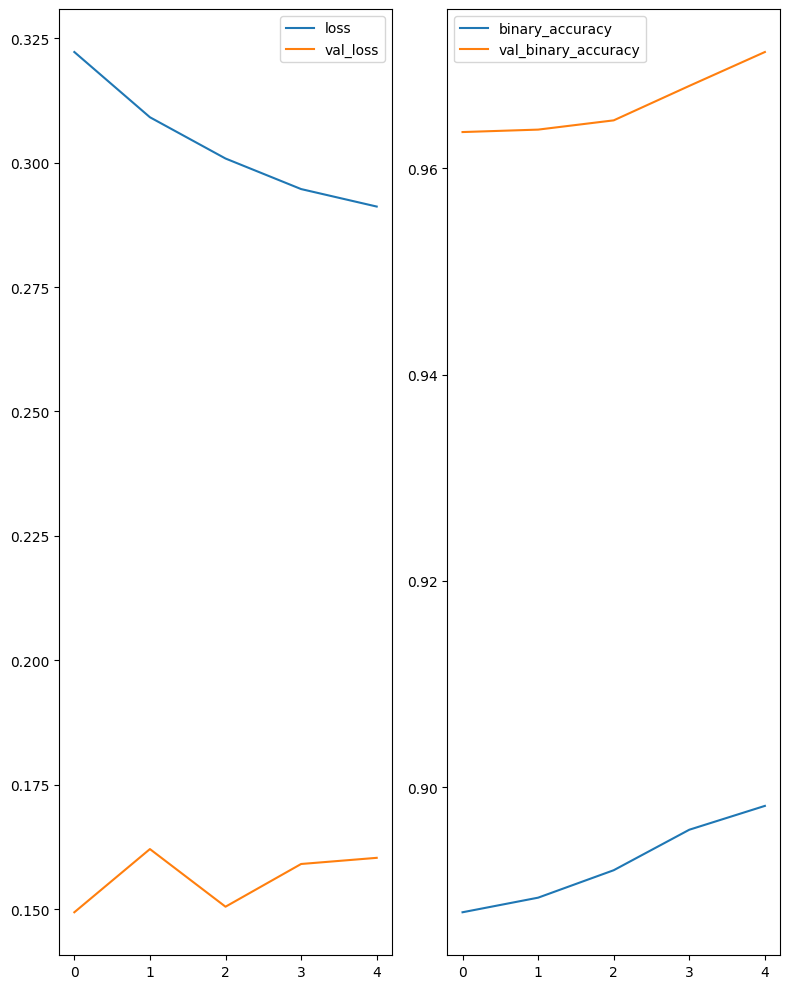

In [59]:
# Application of the history_plot function on the training done
history_plot(hist)

Loss value for the validation set is quite constant during training, while accuracy slightly improve. </br>
Let's take a look to the results on test set. </br>
Considering the imbalanced nature of the dataset, it is crucial to carefully look at results obtained label per label.

In [60]:
# Function to get binary predictions from raw predictions (probabilities)
def get_binary_pred(model, X):
  y_pred_bi = (model.predict(X) > 0.5).astype(int)
  return y_pred_bi

In [61]:
# Application of the function on test dataset
Y_pred_test1 = get_binary_pred(model_basic, X_test_seq_pad)

748/748 ━━━━━━━━━━━━━━━━━━━━ 3s 1000us/step


In [62]:
# Report test set
print(classification_report(Y_test, Y_pred_test1, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.76      0.46      0.58      2294
 severe_toxic       0.53      0.07      0.13       239
      obscene       0.84      0.31      0.45      1267
       threat       0.00      0.00      0.00        72
       insult       0.81      0.21      0.33      1182
identity_hate       0.13      0.01      0.02       211

    micro avg       0.78      0.33      0.46      5265
    macro avg       0.51      0.18      0.25      5265
 weighted avg       0.75      0.33      0.44      5265
  samples avg       0.04      0.03      0.03      5265



We could expect to have all comments classified as non toxic, without any toxicity label: it is not the case. </br>
As there is high imbalance between labels, the metric considered as important to focus on is F1 score, and to evaluate the general prestations on all labels F1 macro average. </br>
The basic model here give 58% on toxic labelled comments, 45% on obscene ones, 33% on insults, 13% for severe_toxic ones, 2% for identity_hate labelled ones and 0% on threats. This order follows the frequency of observations for each label: the higher the number of examples representing a class, the better the model ability to recognize them. </br>
There is a mean value of F1 scores equal to 25%. </br>
Let's see if it would be possible to increase it.

A confusion matrix is created in order to better see what the model predicts for each label.

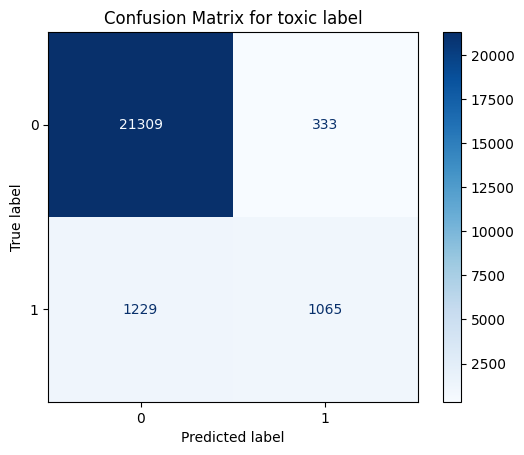

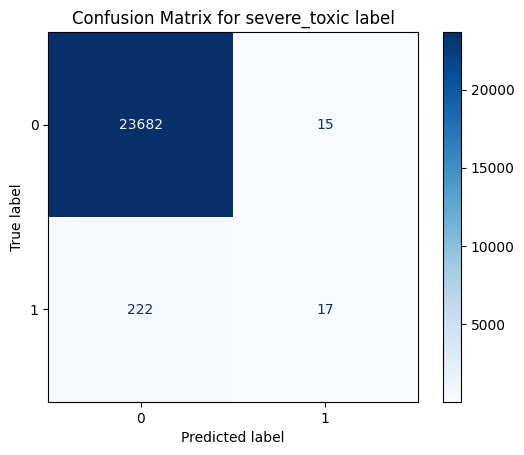

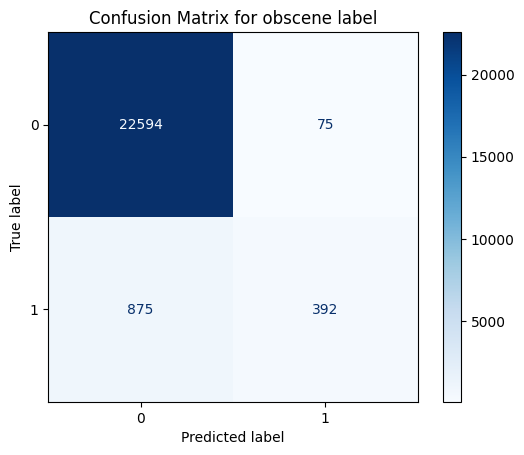

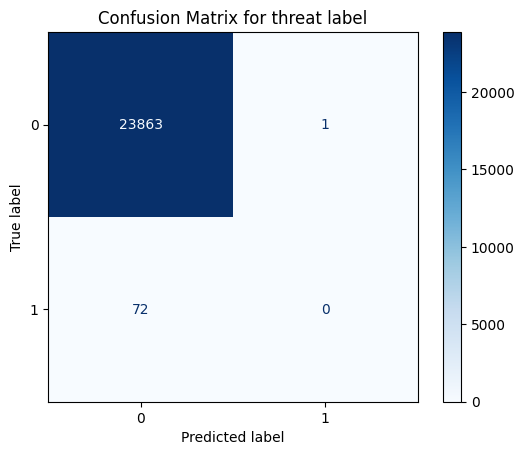

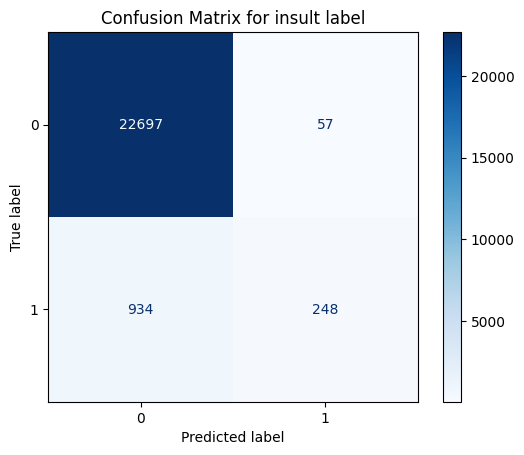

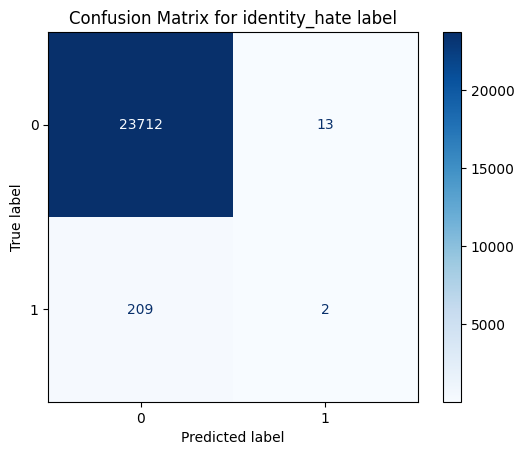

In [63]:
cm = multilabel_confusion_matrix(Y_test, Y_pred_test1)

# Visualization of the confusion matrix for each label
for i, label_name in enumerate(labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {label_name} label')
    plt.show()

In these confusion matrixes, it is visible that the numbers of false negative are always much higher than true positive.

The results obtained by the basic model can be explained by the fact that the model needs to take in account the sequential character of the comments: the order of the words is crucial to fully catch the meaning of the texts. </br> As a result, recurrent layers are introduced in the network.



## 2/ Recurrent Neural Network

In the network architecture, the 1D pooling layer is removed, as there is no need to obtain an only one embedding for each comment: the sequential structure of comments must be kept for the recurrent successive layer. </br>
A first bidirectionnal LSTM layer is added, in order to get information about both previous and further context in the comments. Then a second LSTM layer is here to sum up the entire sequence in an only one vector that represent the whole comment.

In [64]:
# RNN structure, with LSTM layers
def get_model():
    model = Sequential()
    model.add(Embedding(input_dim = voc_size, output_dim = 128, input_length = max_len))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(LSTM(64))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Dense((6), activation = "sigmoid"))
    return model

In [65]:
# Model creation - Compile - Fit
model_RNN = get_model()
model_RNN.compile(optimizer = "RMSprop", loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
#hist = model_RNN.fit(X_train_smote, Y_train_smote, validation_data = (X_val_seq_pad, Y_val), epochs=5, callbacks = [early_stop], verbose=1)

In [66]:
# Save the fitted model
#model_RNN.save("/content/drive/MyDrive/model_rnn.h5")
# Download the fitted model
model_RNN = load_model("/content/drive/MyDrive/model_rnn.h5")

# Save the hist.history dict of training model
#with open("/content/drive/MyDrive/history2.pkl", "wb") as f:
#    pickle.dump(hist.history, f)
# Download the history dict only
with open("/content/drive/MyDrive/history2.pkl", "rb") as f:
    hist = pickle.load(f)

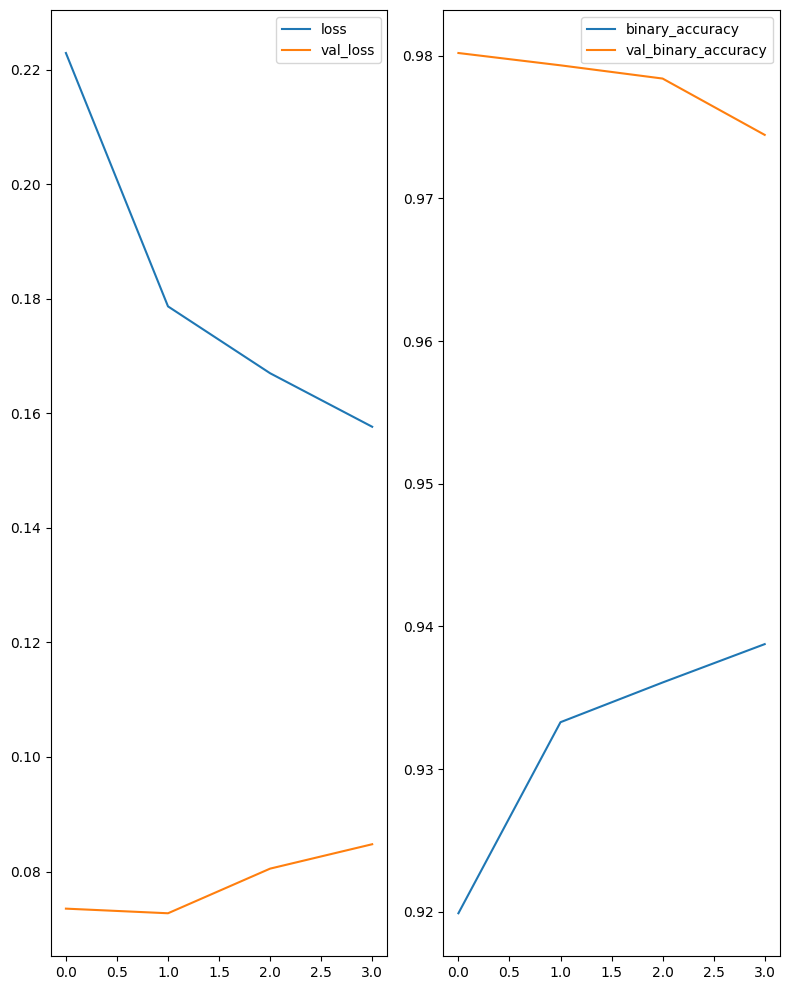

In [67]:
# Plot of the train and validation loss and accuracy values during training
history_plot(hist)

During this training, loss values and accuracy slightly get worse, but they can be considered as stable.

In [68]:
# Report test set
Y_pred_test2 = get_binary_pred(model_RNN, X_test_seq_pad)
print(classification_report(Y_test, Y_pred_test2, target_names=labels))

748/748 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step
               precision    recall  f1-score   support

        toxic       0.78      0.74      0.76      2294
 severe_toxic       0.44      0.02      0.03       239
      obscene       0.77      0.79      0.78      1267
       threat       0.00      0.00      0.00        72
       insult       0.69      0.63      0.66      1182
identity_hate       0.11      0.01      0.03       211

    micro avg       0.75      0.65      0.70      5265
    macro avg       0.47      0.37      0.38      5265
 weighted avg       0.71      0.65      0.67      5265
  samples avg       0.06      0.06      0.06      5265



Compared to the results obtained before without the recurrent layers, here numbers are improved and generally all label F1 scores are higher: </br>
* F1 macro = 38% compared to 25%
* F1 for the highest represented label 'toxic' = 76% compared to 58%
* for the 2 less present labels identity_hate and threat, F1 scores are still very low with 3% and 0%.

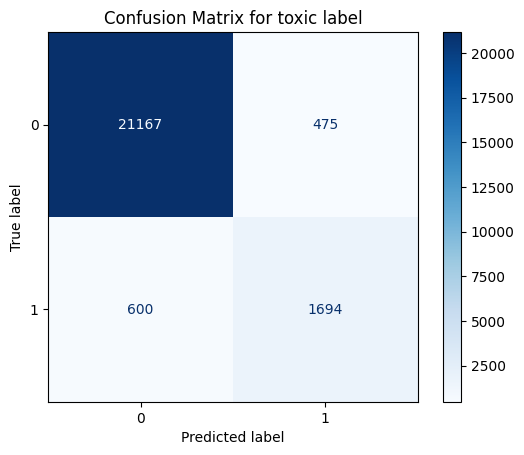

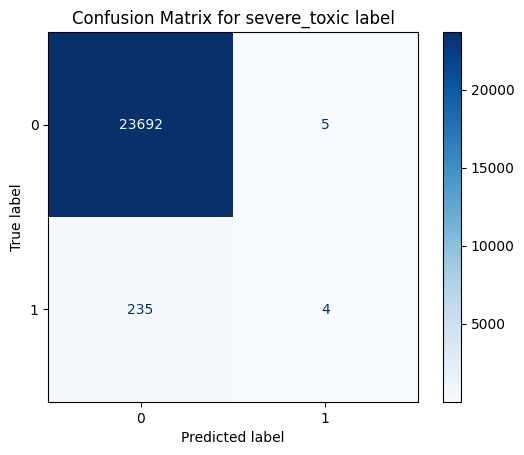

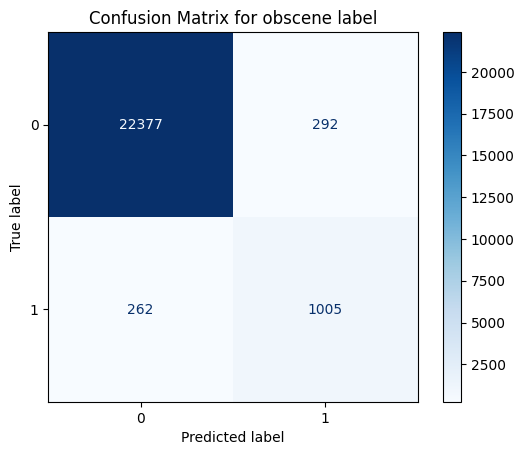

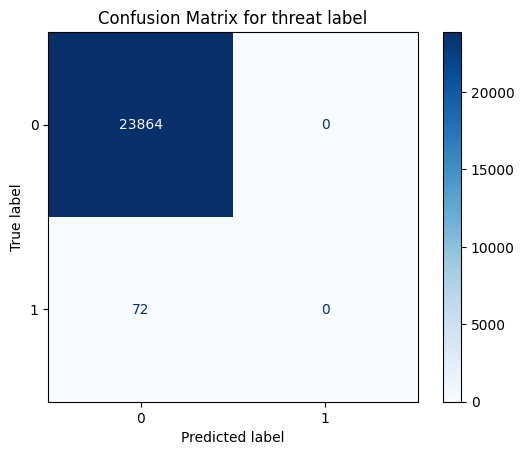

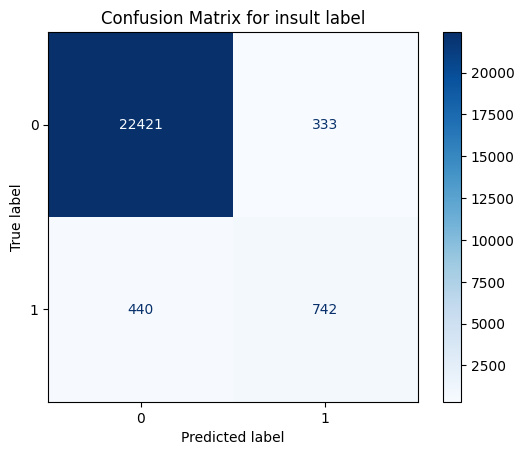

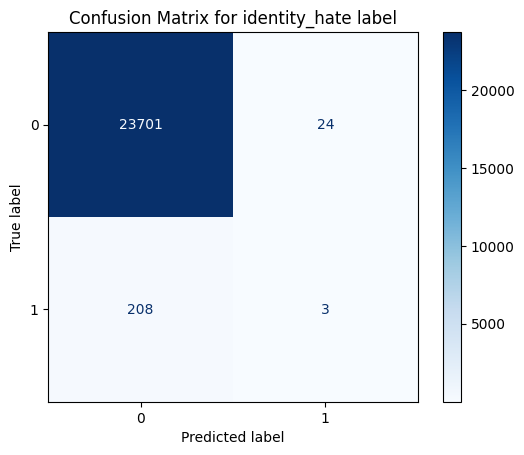

In [69]:
cm = multilabel_confusion_matrix(Y_test, Y_pred_test2)

# Visualization of the confusion matrix for each label
for i, label_name in enumerate(labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {label_name} label')
    plt.show()

Except for the strongliest under-represented labels identity_hate, seevre_toxic and threat, now the number of true positive is higher than the false negative.

## 3/ Use of a weighted loss to handle imbalanced dataset

Another method to deal with imbalanced dataset is to create a weighted binary crossentropy, with calculated weights for each label, able to compensate for the loss calculation and minimization during training the low label frequencies.

Creation of a custom loss function with label weights to treat the imbalance in the dataset.

In [70]:
# y_train.shape = (num_samples, num_labels)
num_labels = len(labels)
# Initialization of weight matrix with all zeros
weights = np.zeros(num_labels)

# For each label, counts of number of positive and negative observations
for i in range(num_labels):
    num_pos = np.sum(Y_train.iloc[:, i] == 1)
    num_neg = np.sum(Y_train.iloc[:, i] == 0)
    # weights inversely proportionnal to label frequency
    weights[i] = num_neg / num_pos

def weighted_bce(weights):
    # Conversion of weights in tensorflow tensor and reshape in row tensor
    weights = tf.reshape(tf.constant(weights, dtype=tf.float32), (1, -1))

    def loss(y_true, y_pred):
        # Cast in float32 to garantee numerical compatibility with tensorflow
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Classic binary crossentropy formula
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # return the weighted binary crossentropy
        return tf.reduce_mean(bce * weights)

    return loss

loss_fn = weighted_bce(weights)

In [71]:
# Model creation
model_RNN_weights = get_model()

In [72]:
# Model compile
model_RNN_weights.compile(optimizer='RMSprop', loss=loss_fn, metrics=['binary_accuracy'], run_eagerly=True)

In [73]:
# Fitting on train set
#hist = model_RNN_weights.fit(X_train_smote, Y_train_smote, validation_data = (X_val_seq_pad, Y_val), epochs=5, callbacks = [early_stop], verbose=1)

In [74]:
# Save the fitted model
#model_RNN_weights.save("/content/drive/MyDrive/model_rnn_weights.keras")
# Download the fitted model
model_RNN_weights = load_model("/content/drive/MyDrive/model_rnn_weights.keras", compile = False)

In [75]:
# Save the hist.history dict of training model
#with open("/content/drive/MyDrive/history3.pkl", "wb") as f:
#    pickle.dump(hist.history, f)
# Download the history dict only
with open("/content/drive/MyDrive/history3.pkl", "rb") as f:
    hist = pickle.load(f)

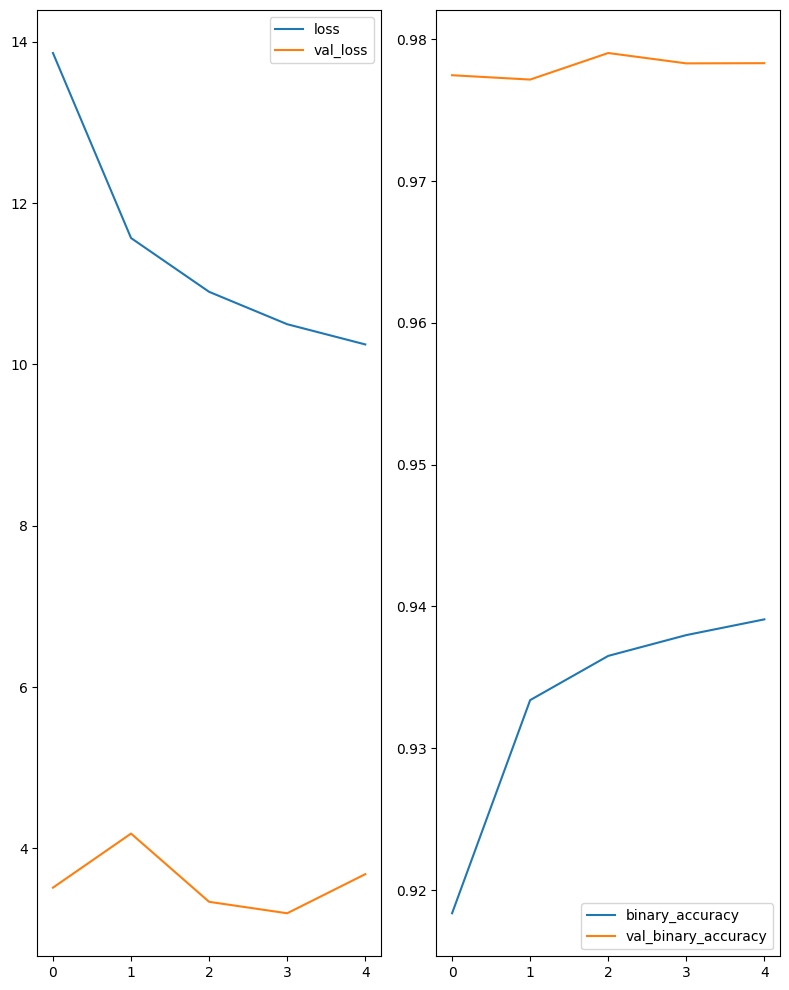

In [76]:
# Plot of the train and validation loss and accuracy values during training
history_plot(hist)

Validation set metrics are stable during the training. </br>
Of course loss values are really higher compared to the one obtained in the last model training, as here the loss considers labels weights and this lead to a final loss value much higher if the labelled examples are not well labelled.

In [77]:
# Report test set
Y_pred_test3 = get_binary_pred(model_RNN_weights, X_test_seq_pad)
print(classification_report(Y_test, Y_pred_test3, target_names=labels))

748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
               precision    recall  f1-score   support

        toxic       0.77      0.73      0.75      2294
 severe_toxic       0.50      0.42      0.46       239
      obscene       0.76      0.80      0.78      1267
       threat       0.45      0.19      0.27        72
       insult       0.66      0.69      0.67      1182
identity_hate       0.51      0.44      0.47       211

    micro avg       0.72      0.70      0.71      5265
    macro avg       0.61      0.54      0.57      5265
 weighted avg       0.71      0.70      0.71      5265
  samples avg       0.06      0.06      0.06      5265



These results are better again compared to the previous ones:
* F1 score macro equals to 57%, vs 38% for the model with custom loss;
* The performances on the most frequent labels are unchanged;
* F1 scores for the rarest labels are much better: from 3% to 46% for the severe_toxic labelled comments, from 0% to 27% for threat labelled ones, and from 3% to 47% per identity_hate labelled ones.

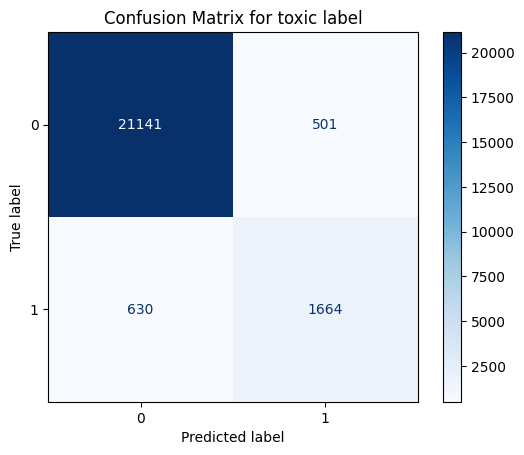

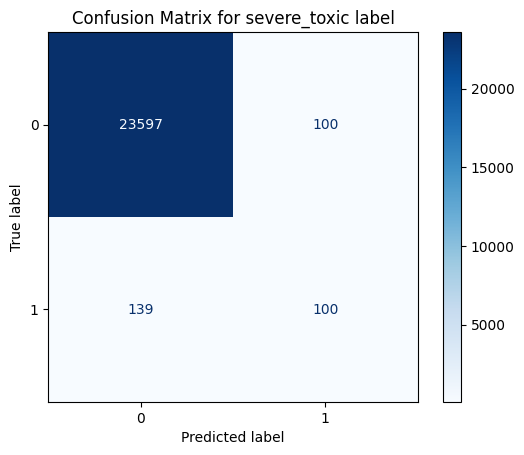

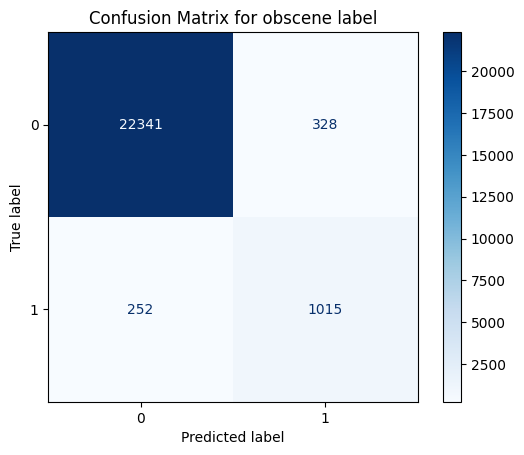

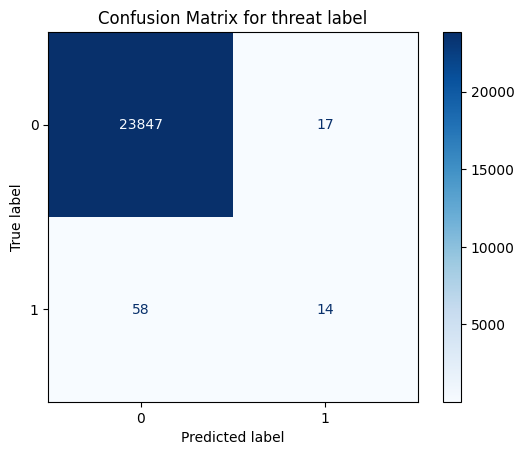

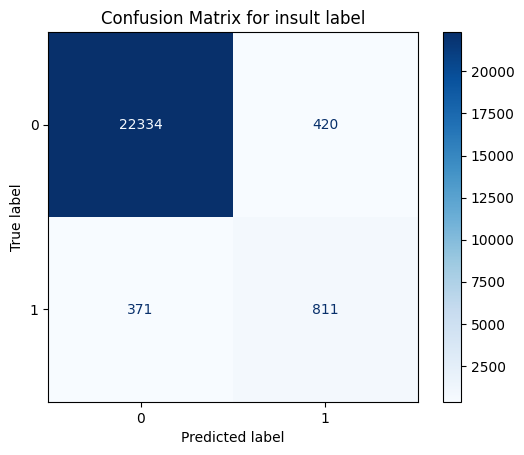

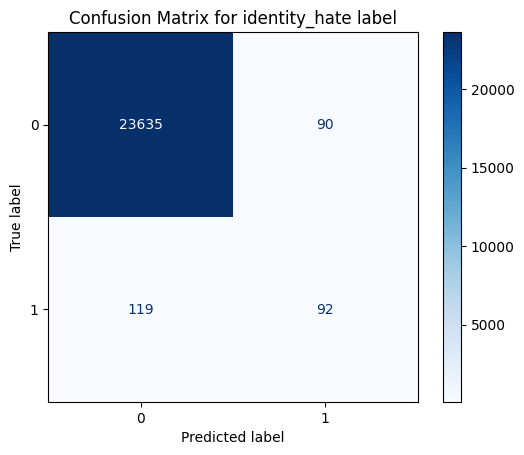

In [78]:
cm = multilabel_confusion_matrix(Y_test, Y_pred_test3)

# Visualization of the confusion matrix for each label
for i, label_name in enumerate(labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {label_name} label')
    plt.show()

As visible in the confusion matrixes, the number of false negative is still high. A modification of the threshold value in the calculation of predictions from probabilities could lead to better performances.

## 4/ Threshold value modification from probabilities to predictions

The best model so far on the dataset is the RNN one with custom weighted loss. </br>
After model training, predictions are calculated from labels probabilities, and the function defined so far took a threshold equal to 0.5. </br>
It is interesting to study the impact of the threshold modification on the final results.

748/748 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step
For threshold of 0.2:
               precision    recall  f1-score   support

        toxic       0.48      0.84      0.61      2294
 severe_toxic       0.20      0.81      0.33       239
      obscene       0.48      0.91      0.63      1267
       threat       0.24      0.42      0.30        72
       insult       0.40      0.86      0.55      1182
identity_hate       0.13      0.64      0.21       211

    micro avg       0.40      0.85      0.55      5265
    macro avg       0.32      0.75      0.44      5265
 weighted avg       0.43      0.85      0.57      5265
  samples avg       0.06      0.08      0.06      5265

----------------------------------------------------------------
748/748 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
For threshold of 0.25:
               precision    recall  f1-score   support

        toxic       0.54      0.82      0.65      2294
 severe_toxic       0.25      0.76      0.38       239
      obscene       0.54      0.

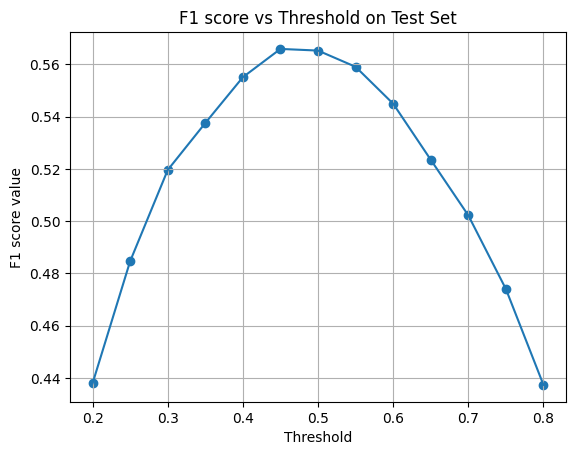

In [80]:
# For threshold values between 0.2 and 0.8, calculation on test set of precision and classification report
f1_list =[]
thresholds_list = []

for i in np.arange(0.2, 0.8, 0.05):
  Y_pred_test4 = (model_RNN_weights.predict(X_test_seq_pad) > i).astype(int)
  f1 = f1_score(Y_test, Y_pred_test4, average='macro')
  f1_list.append(f1)
  thresholds_list.append(i)
  print(f"For threshold of {i}:")
  print(classification_report(Y_test, Y_pred_test4, target_names=labels))
  print("----------------------------------------------------------------")

# Plot of precision vs threshold values
plt.plot(thresholds_list, f1_list)
plt.scatter(thresholds_list, f1_list)
plt.xlabel("Threshold")
plt.ylabel("F1 score value")
plt.title("F1 score vs Threshold on Test Set")
plt.grid(True)
plt.show()

The plot shows a maximum of F1 score for threshold values of 0.45 - 0.5. As a result, it is natural to keep the default value of 0.5.

# Inference Phase

The best model tested so far has now to be tested on new comments.

In [126]:
# 2 comments are considered: a regular non-toxic and a toxic one
comment_1 = "Thank you for this article, so useful."
comment_2 = "No one cares about your opinion; you're an idiot, just stop posting!"

In [119]:
# For dimension matter, a special function is created to take single string and perform tokenization and padding
def text_to_seq_single(sentence, tokenizer):
    seq = tokenizer.texts_to_sequences([sentence])
    return pad_sequences(seq, maxlen=max_len)

In [120]:
# Function to obtain prediction vector from a comment
def prediction(sentence, tokenizer, model):
  sentence = data_cleaner(sentence)
  seq_pad = text_to_seq_single(sentence, tokenizer)
  pred = get_binary_pred(model, seq_pad)
  return pred

In [121]:
# Prediction calculation for regular comment
prediction(comment_1, tokenizer, model_RNN_weights)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0, 0, 0, 0, 0, 0]])

In [127]:
# Prediction calculation for toxic comment
prediction(comment_2, tokenizer, model_RNN_weights)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[1, 0, 1, 0, 1, 0]])


The regular comment doesn't present any toxicity label, while the toxic one has been labelled as toxic, obscene and insult, which is pretty what it is.

# Conclusion

This project was about creating a multi label classification model, from a highly imbalanced dataset of comments. </br>
During the preprocessing phase, data augmentation has been done using additional labelled toxic comments, then tokenization has been done on all real comments, and finally artificial sequences have been dreated using MLSMOTE method. </br>
A first neural network model without recurrent layer showed weak results, as expected. </br>
The second model with LSTM recurrent layers gave better results, furthermore improved using a custom weighted loss function.</br>
Finally, the model has been tested with success on both toxic and not toxic comments.